# Text Frecuency - Inverse Document Frequency

- $w_{tf}$: frecuencia de aparición de una palabra en un documento
- $w_{df}$: frecuencia total de aparición de una palabra en el conjunto de todos los documentos (corpus)

$$w_{tf-idf} = w_{tf}\cdot \log\left(\frac{1}{w_{df}}\right)$$

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
session = tf.Session()
batch_size = 200
max_features = 1000

In [5]:
import os
save_file_name = os.path.join('..','..','datasets', 'spam_data.csv')

text_data = []
with open(save_file_name, 'r') as temp_output_file:
    reader = csv.reader(temp_output_file)
    for row in reader:
        text_data.append(row)

In [7]:
texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]
target = [1 if x == 'spam' else 0 for x in target]

In [8]:
texts = [x.lower() for x in texts] # Convertir los textos a minúscula
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts] # Eliminamos signos de puntuación
texts = [''.join(c for c in x if c not in '0123456789') for x in texts] # Eliminamos los números
texts = [' '.join(x.split()) for x in texts] # Eliminar espacios en blanco y separadores extras

In [9]:
def tokenizer(text):
    words = nltk.word_tokenize(text)
    return words

In [14]:
tfidf = TfidfVectorizer(tokenizer=tokenizer, stop_words='english', max_features=max_features)

In [16]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juangabriel/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
sparse_tfidf_texts = tfidf.fit_transform(texts)

In [18]:
sparse_tfidf_texts

<5574x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 30012 stored elements in Compressed Sparse Row format>

La matriz sparsed después de ser tokenizada, contiene 
- tantas filas como la longitud de: `len(texts)`
- tantas columnas como palabras importantes hemos extraido del proceso de tokenización (las `max_features` importantes)
- es una matriz sparsed, donde en fila i, columna j contiene la frecuencia de aparición de la palabra i en el texto j, que hemos llamado $w_{tf-idf}$ (probablemente cero en la mayoría de casos)

In [20]:
sparse_tfidf_texts.shape

(5574, 1000)

In [22]:
train_idx = np.random.choice(sparse_tfidf_texts.shape[0], round(0.8*sparse_tfidf_texts.shape[0]), replace=False)
test_idx = np.array(list(set(range(sparse_tfidf_texts.shape[0]))-set(train_idx)))

In [23]:
texts_train = sparse_tfidf_texts[train_idx]
texts_test = sparse_tfidf_texts[test_idx]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_idx])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_idx])

In [24]:
A = tf.Variable(tf.random_normal(shape = [max_features, 1]))
b = tf.Variable(tf.random_normal(shape = [1,1]))
x_data = tf.placeholder(shape = [None, max_features], dtype = tf.float32)
y_target = tf.placeholder(shape = [None, 1], dtype = tf.float32)

In [25]:
model_output = tf.add(tf.matmul(x_data, A), b)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

In [26]:
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

In [27]:
my_optim = tf.train.GradientDescentOptimizer(0.0025)
train_step = my_optim.minimize(loss)
init = tf.global_variables_initializer()
session.run(init)

In [30]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []

for i in range(10000):
    rand_idx = np.random.choice(texts_train.shape[0], size = batch_size)
    rand_x = texts_train[rand_idx].todense()
    rand_y = np.transpose([target_train[rand_idx]])
    session.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    if(i+1)%100==0:
        i_data.append(i+1)
        
        train_loss_temp = session.run(loss, feed_dict={x_data:rand_x, y_target:rand_y})
        train_loss.append(train_loss_temp)
        
        test_loss_temp = session.run(loss, feed_dict={x_data:texts_test.todense(), 
                                                      y_target:np.transpose([target_test])})
        test_loss.append(test_loss_temp)
        
        train_acc_temp = session.run(accuracy, feed_dict={x_data: rand_x, y_target: rand_y})
        train_acc.append(train_acc_temp)
        
        test_acc_temp = session.run(accuracy, feed_dict={x_data: texts_test.todense(), 
                                                         y_target: np.transpose([target_test])})
        test_acc.append(test_acc_temp)
        
    if(i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,3) for x in acc_and_loss]
        print("Paso #{}. Train loss: {}. Test Loss: {}.\n  Train Acc: {}. Test Acc:{}.".format(*acc_and_loss))

Paso #500. Train loss: 0.5709999799728394. Test Loss: 0.5170000195503235.
  Train Acc: 0.7099999785423279. Test Acc:0.7770000100135803.
Paso #1000. Train loss: 0.5509999990463257. Test Loss: 0.4880000054836273.
  Train Acc: 0.7450000047683716. Test Acc:0.8040000200271606.
Paso #1500. Train loss: 0.47200000286102295. Test Loss: 0.4690000116825104.
  Train Acc: 0.8149999976158142. Test Acc:0.8199999928474426.
Paso #2000. Train loss: 0.48399999737739563. Test Loss: 0.4560000002384186.
  Train Acc: 0.8149999976158142. Test Acc:0.8330000042915344.
Paso #2500. Train loss: 0.4180000126361847. Test Loss: 0.44600000977516174.
  Train Acc: 0.8949999809265137. Test Acc:0.8410000205039978.
Paso #3000. Train loss: 0.4429999887943268. Test Loss: 0.4390000104904175.
  Train Acc: 0.824999988079071. Test Acc:0.847000002861023.
Paso #3500. Train loss: 0.5289999842643738. Test Loss: 0.4339999854564667.
  Train Acc: 0.8149999976158142. Test Acc:0.8479999899864197.
Paso #4000. Train loss: 0.384000003337860

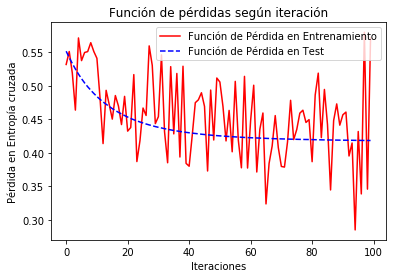

In [31]:
plt.plot(train_loss, 'r-', label = "Función de Pérdida en Entrenamiento")
plt.plot(test_loss, 'b--', label = "Función de Pérdida en Test")
plt.legend(loc="upper right")
plt.xlabel("Iteraciones")
plt.ylabel("Pérdida en Entropía cruzada")
plt.title("Función de pérdidas según iteración")
plt.show()

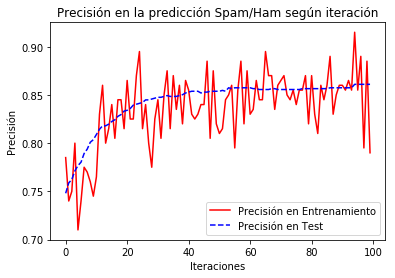

In [32]:
plt.plot(train_acc, 'r-', label = "Precisión en Entrenamiento")
plt.plot(test_acc, 'b--', label = "Precisión en Test")
plt.legend(loc="lower right")
plt.xlabel("Iteraciones")
plt.ylabel("Precisión")
plt.title("Precisión en la predicción Spam/Ham según iteración")
plt.show()